In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
import keras_tuner as kt


# Import the Data - ml_injury_tracking

This dataset merged the three tables from the Injury set, combining the game and play information, the injury type and its severity, as well as the tracking positions of the injury data. This dataset only includes the injury data, as all "NoInjury" rows were excluded. Therefore, the analyses that will be performed will be the prediction of severity of the injury or the type of the injury. 

In [24]:
ml_injuries = pd.read_csv("Shared_Tables/ml_injury_tracking.csv")
seed = 42

ml_injuries.head()

,PlayKey,time,x,y,dir,dis,o,s,RosterPosition,Temperature,PlayerGamePlay,Position,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,InjuryType,InjuryDuration,SevereInjury
0,31070-3-7,0.0,44.07,32.14,23.31,0.0,174.83,0.03,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
1,31070-3-7,0.1,44.08,32.14,20.18,0.0,175.09,0.03,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
2,31070-3-7,0.2,44.08,32.14,16.53,0.0,175.35,0.03,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
3,31070-3-7,0.3,44.08,32.14,13.23,0.0,175.60,0.02,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
4,31070-3-7,0.4,44.08,32.14,9.78,0.0,175.82,0.02,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0


# Prepare the Training and Testing sets

Columns that need to be removed or separated:
- PlayKey is non-informative and object-type
- SevereInjury and InjuryDuration cannot be part of the same training set, as they are not independent 
- For one of the analyses, InjuryType will be the prediction, so we want to exclude the InjuryDuration and SevereInjury, as we're trying to determine the other factors leading to such injuries
- In predicting the severity and/or duration of injury, a few sub-analyses can be performed
    - Looking only at factors that lead to severe injury without respect to injury type
    - Looking at the factors including injury type that predict the duration of injury
    - Looking at the factors that predict BOTH injury type and Severity (or perhaps duration)


---

## InjuryType Prediction

In [33]:
ml_type = ml_injuries.copy(deep=True)

# Prepare the InjuryType Prediction Dataset
y = ml_type.InjuryType
X = ml_type.drop(columns=['PlayKey', 'InjuryDuration', 'SevereInjury', 'InjuryType', 'RosterPosition', 'dis', 'time'])

In [34]:
y.value_counts()

48.0    10827
42.0    10225
7.0      1723
Name: InjuryType, dtype: int64

Split the training data using train_test_split from scikit learn

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

## Random Forest


In [36]:
# Create the Classifier
barf = BalancedRandomForestClassifier(n_estimators=10, random_state=seed)

# Fit the model
barf.fit(X_train, y_train)

# Calculate predicted accuracy score
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9778840024389573

c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


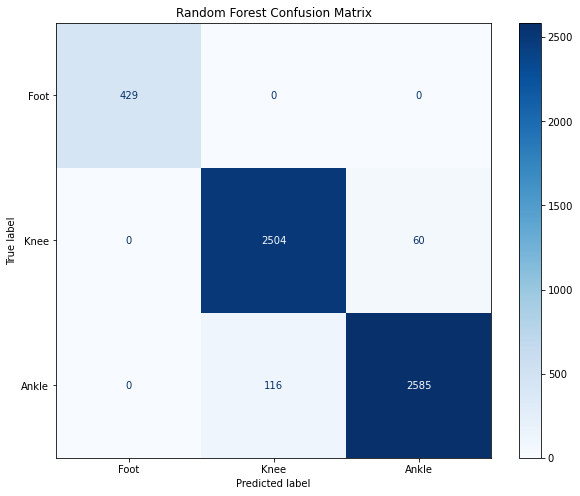

In [37]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(barf, X_test, y_test, display_labels=[
                      "Foot", "Ankle", "Knee"], cmap='Blues', values_format='d', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

Results: 
- The Random Forest Classifier with 10 estimators yielded a 97.6% accuracy
- All foot injuries were properly classified

To further assess which features influenced the model the most, we will perform a feature analysis

In [38]:
sorted(zip(barf.feature_importances_, X.columns), reverse=True)

[(0.23212771302515417, 'PlayerGamePlay'),
 (0.1435282362032859, 'Position'),
 (0.12821742293701277, 'Temperature'),
 (0.12537547304052588, 'x'),
 (0.1114886491824457, 'DaysPlayed'),
 (0.07389580748151864, 'y'),
 (0.057561627293617156, 'PlayCode'),
 (0.03218385263483276, 'SyntheticField'),
 (0.029579603299437995, 'Outdoor'),
 (0.02638933082168734, 'o'),
 (0.017313267586401098, 'Precipitation'),
 (0.013333319549492972, 's'),
 (0.009005696944587768, 'dir')]

### What does this mean? 
- The PlayerGamePlay represents how far into the game, where plays under 35 are typically within the first half of the game, which constituted 23.2% impact on the analysis
- The position is the actual position of the play, separating the difference between an Outer or Inner Linebacker and such, which made up 14.4% of the predictive capacity
- The temperature of the game was a much better predictor than the presence of precipitation - this will be interesting to compare with unsupervised categorical classification, ultimately 12.8% of the predictive influence
- x is the position on the field along the length of the field, where 0 represents the Home Endzone and 120 is the Away Endzone, this had a 12.5% impact
- DaysPlayed represents how far into the season the player is, consituting 11.1% impact on the prediction
- y is the position on the field width-wise, providing a 7.4% impact 
- The play code and sythetic field parameters only made up 5.7% and 3.2% of the predictive influence, respectively

Changes: 
- Distance traveled and speed were among the lowest - though upon this analysis, it appears that the distance, time, and estimated speed are not independent, so the time and dis will be removed, maintaining the s column, predicted speed 
- After doing this, speed still remains one of the least impactful predictors, but it increased the predictive power of the other features 
- Since the RosterPosition isn't completely independent, this analysis was re-run without the RosterPosition, only maintaining the Position


---

# Deep Learning with Neural Networks

In [103]:
ml_injuries = pd.read_csv("Shared_Tables/ml_injury_tracking.csv")
ml_type = ml_injuries.copy(deep=True)
ml_type.drop(columns=['PlayKey', 'InjuryDuration', 'SevereInjury', 'RosterPosition', 'dis', 'time'], inplace=True)


# Add the Injury Type back to the df
injury = {48.0: 'Knee', 42.0: 'Ankle', 7.0: 'Foot'}
ml_type['BodyPart'] = ml_type.InjuryType.map(injury)
ml_type.drop(columns='InjuryType', inplace=True)

# Grab all categorical variables and create a list for encoding
cat = ml_type.dtypes[ml_type.dtypes=='object'].index.tolist()

For the Neural Network Analysis, we will need to have each outcome as a binary classification, thus encoding the Injury types differently with OneHotEncoder

In [104]:
# Create the instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OHE to the columns necessary
encode_df = pd.DataFrame(enc.fit_transform(ml_type[cat]))

# Add the original variable names to the df
encode_df.columns = enc.get_feature_names_out(cat)
encode_df.head()


,BodyPart_Ankle,BodyPart_Foot,BodyPart_Knee
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [105]:
# Merge the OHE features and drop the variables
ml_encoded = ml_type.merge(encode_df, left_index=True, right_index=True)
ml_encoded.drop(columns=cat, inplace=True)

In [106]:
ml_encoded.head

,x,y,dir,o,s,Temperature,PlayerGamePlay,Position,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,BodyPart_Ankle,BodyPart_Foot,BodyPart_Knee
0,44.07,32.14,23.31,174.83,0.03,89,7,1,0,1,0,78,1.0,0.0,0.0,1.0
1,44.08,32.14,20.18,175.09,0.03,89,7,1,0,1,0,78,1.0,0.0,0.0,1.0
2,44.08,32.14,16.53,175.35,0.03,89,7,1,0,1,0,78,1.0,0.0,0.0,1.0
3,44.08,32.14,13.23,175.60,0.02,89,7,1,0,1,0,78,1.0,0.0,0.0,1.0
4,44.08,32.14,9.78,175.82,0.02,89,7,1,0,1,0,78,1.0,0.0,0.0,1.0


In [116]:
# Prepare the InjuryType Prediction Dataset
y = ml_encoded.loc[:, 'BodyPart_Ankle':]
X = ml_encoded.drop(columns=['BodyPart_Ankle','BodyPart_Foot', 'BodyPart_Knee'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)


In [118]:
scaler = StandardScaler()
X_scaled = scaler.fit(X_train)
X_train_scaled = X_scaled.transform(X_train)
X_test_scaled = X_scaled.transform(X_test)

In [148]:
number_input_features = len(X_train_scaled[0])
hidden_layer1 = 120
hidden_layer2 = 250

nn = tf.keras.models.Sequential()

# Layers
nn.add(tf.keras.layers.Dense(units=hidden_layer1, input_dim=number_input_features, activation='relu'))
# nn.add(tf.keras.layers.Dense(units=hidden_layer2, activation='relu'))
nn.add(tf.keras.layers.Dense(units=3, activation='sigmoid'))

nn.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 120)               1680      
                                                                 
 dense_36 (Dense)            (None, 3)                 363       
                                                                 
Total params: 2,043
Trainable params: 2,043
Non-trainable params: 0
_________________________________________________________________


In [149]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [150]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)


Epoch 1/50
534/534 [==============================] - 1s 820us/step - loss: 0.3804 - accuracy: 0.7519
Epoch 2/50
534/534 [==============================] - 0s 835us/step - loss: 0.1865 - accuracy: 0.9107
Epoch 3/50
534/534 [==============================] - 0s 788us/step - loss: 0.1171 - accuracy: 0.9522
Epoch 4/50
534/534 [==============================] - 0s 833us/step - loss: 0.0810 - accuracy: 0.9669
Epoch 5/50
534/534 [==============================] - 0s 794us/step - loss: 0.0611 - accuracy: 0.9727
Epoch 6/50
534/534 [==============================] - 0s 829us/step - loss: 0.0496 - accuracy: 0.9750
Epoch 7/50
534/534 [==============================] - 0s 818us/step - loss: 0.0425 - accuracy: 0.9742
Epoch 8/50
534/534 [==============================] - 0s 794us/step - loss: 0.0384 - accuracy: 0.9732
Epoch 9/50
534/534 [==============================] - 0s 803us/step - loss: 0.0342 - accuracy: 0.9756
Epoch 10/50
534/534 [==============================] - 1s 1ms/step - loss: 0.0322 

In [151]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


178/178 - 0s - loss: 0.0264 - accuracy: 0.9735 - 187ms/epoch - 1ms/step
Loss: 0.026397626847028732, Accuracy: 0.9734808802604675
